In [62]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

import xflib
# Coordinate transformation library
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
import matplotlib.gridspec as gridspec




from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from scipy.optimize import curve_fit
from sklearn import mixture

def f_gaus(x,*p):
    n_gauss = 2
    out=0
    return p[0]*np.exp(-np.abs((x-p[1])/p[2])**2) + \
           p[3]*np.exp(-np.abs((x-p[4])/p[5])**2) + p[6] + p[7]*x + p[8]*x*x
    
iri_day = np.loadtxt('/shared/users/asousa/WIPP/lightning_power_study/python/iri_dayside_1500km_with_f2peak.dat')

lats = iri_day[:,1]
alts = iri_day[:,0]
dens_day = iri_day[:,3]*1e-6
f2_alts_day = iri_day[:,4]
f2_dens_day = iri_day[:,5]*1e-6

D2R = np.pi/180.
R2D = 180./np.pi

grad_day = (np.log10(dens_day) - np.log10(f2_dens_day))/(alts - f2_alts_day)
grad_params_day = np.polyfit(lats, grad_day, 10)
grad_fit_day = np.poly1d(grad_params_day)

pguess = [1200000, -18, 15, 700000, 15, 20, 200000, 0.1, 0]
f2_params_day, covs = curve_fit(f_gaus, lats, f2_dens_day, p0 = pguess)
f2_dens_fit_day = f_gaus(lats, *f2_params_day)

edge_params_day, covs = curve_fit(f_gaus, lats, dens_day, p0 = pguess)

iri_nite = np.loadtxt('/shared/users/asousa/WIPP/lightning_power_study/python/iri_nightside_1500km_with_f2peak.dat')

lats = iri_nite[:,1]
alts = iri_nite[:,0]
dens_nite = iri_nite[:,3]*1e-6
f2_alts_nite = iri_nite[:,4]
f2_dens_nite = iri_nite[:,5]*1e-6

D2R = np.pi/180.
R2D = 180./np.pi

grad_nite = (np.log10(dens_nite) - np.log10(f2_dens_nite))/(alts - f2_alts_nite)
grad_params_nite = np.polyfit(lats, grad_nite, 10)
grad_fit_nite = np.poly1d(grad_params_nite)

pguess = [1200000, -18, 15, 700000, 15, 20, 200000, 0.1, 0]
f2_params_nite, covs = curve_fit(f_gaus, lats, f2_dens_nite, p0 = pguess)
f2_dens_fit_nite = f_gaus(lats, *f2_params_nite)

edge_params_nite, covs = curve_fit(f_gaus, lats, dens, p0 = pguess)





In [45]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5 
fig_height = 2.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

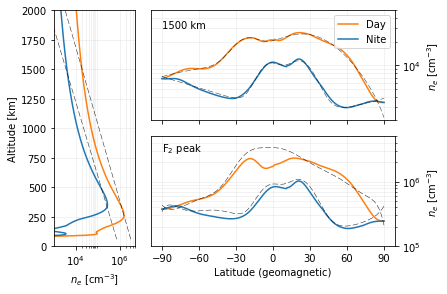

In [128]:
iri_day_altitude = np.loadtxt('data/iri_dayside_altitude_profile.txt')
iri_nite_altitude = np.loadtxt('data/iri_nightside_altitude_profile.txt')

alt = iri_day_altitude[:,4]
ne_day = iri_day_altitude[:,7]*1e-6
ne_nite = iri_nite_altitude[:,7]*1e-6
lat = iri_day_altitude[0,5]

fit_day  = f_gaus(lat, *edge_params_day)*pow(10.0,grad_fit_day(lat)*(alt - 1500.0))
fit_nite = f_gaus(lat, *edge_params_nite)*pow(10.0,grad_fit_nite(lat)*(alt - 1500.0))




# fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios':[0.4,1]})
fig = plt.figure()
gs = gridspec.GridSpec(2,2,width_ratios=[1,3])
ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])



daycolor = plt.cm.Vega10(1)
nitecolor= plt.cm.Vega10(0)

ax0.plot(ne_day, alt,  color = daycolor,  label='Day')
ax0.plot(ne_nite, alt, color = nitecolor, label='Nite')
ax0.plot(fit_day, alt, color = 'k', linestyle='--', linewidth=0.5, alpha=0.9)
ax0.plot(fit_nite, alt,color = 'k', linestyle='--', linewidth=0.5, alpha=0.9)
ax0.set_xscale('log')
ax0.set_xlim([1e3, 5e6])
ax0.grid('on', which='both', alpha=0.3, linewidth=0.5)
ax0.set_xlabel('$n_e$ [cm$^{-3}$]')
ax0.set_ylabel('Altitude [km]')
# ax0.legend()

ax0.set_ylim([0,2000])

alt = 1500
fit_day_1500  = f_gaus(lats, *edge_params_day)*pow(10.0,grad_fit_day(lats)*(alt - 1500.0))
fit_nite_1500 = f_gaus(lats, *edge_params_nite)*pow(10.0,grad_fit_nite(lats)*(alt - 1500.0))

alt=300
fit_day_f2  = f_gaus(lats, *edge_params_day)*pow(10.0,grad_fit_day(lats)*(alt - 1500.0))
alt=320
fit_nite_f2 = f_gaus(lats, *edge_params_nite)*pow(10.0,grad_fit_nite(lats)*(alt - 1500.0))



ax1.plot(lats, dens_day, color=daycolor, label='Day')
ax1.plot(lats, dens_nite, color=nitecolor, label='Nite')

ax1.plot(lats, fit_day_1500, 'k', linestyle='dashed', alpha=0.8, linewidth=0.5)
ax1.plot(lats, fit_nite_1500, 'k', linestyle='dashed', alpha=0.8, linewidth=0.5)

ax2.plot(lats, f2_dens_day, color=daycolor)
ax2.plot(lats, f2_dens_nite, color=nitecolor)
ax2.plot(lats, fit_day_f2, 'k', linestyle='dashed', alpha=0.9, linewidth=0.5)
ax2.plot(lats, fit_nite_f2, 'k', linestyle='dashed', alpha=0.9, linewidth=0.5)



ax1.legend(loc='upper right')

ax1.set_ylabel('$n_e$ [cm$^{-3}$]')
ax2.set_ylabel('$n_e$ [cm$^{-3}$]')
# ax0.set_title('(a)')
# ax1.set_title('(b)')
# ax2.set_title('(c)')



ax1.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax2.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax2.set_xlabel('Latitude (geomagnetic)')
ax1.set_xticklabels([])



ax1.set_yticks([2e3, 1e4, 5e4])
ax2.set_yticks([1e5, 1e6, 5e6])
ax1.set_ylim([2e3, 5e4+1])
ax2.set_ylim([1e5, 5e6+1])

ax1.yaxis.tick_right()
ax2.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('right')

ax1.set_yscale('log')
ax2.set_yscale('log')


ax1.grid('on', which='both', alpha=0.3, linewidth=0.5)
ax2.grid('on', which='both', alpha=0.3, linewidth=0.5)

ax1.text(-90,3e4, '1500 km')
ax2.text(-90, 3e6, 'F$_2$ peak')
fig.savefig('iono_profile.pdf')
fig.tight_layout()

In [80]:
fit_day_f2

array([  512383.45243459,   502865.05854526,   494082.4508319 ,
         486024.74586261,   478677.45199994,   472023.3663535 ,
         466043.31280677,   460716.74248052,   456022.21624876,
         451937.78701616,   448441.29752722,   445510.60759486,
         443123.76286504,   441259.11560678,   439895.40654844,
         439011.81547408,   438587.98714485,   438604.03810809,
         439040.54909004,   439878.54692201,   441099.47931065,
         442685.18521628,   444617.86313682,   446880.03919574,
         449454.53659145,   452324.44767159,   455473.10964249,
         458884.08470359,   462541.14520353,   466428.26424472,
         470529.61201209,   474829.55796719,   479312.67892826,
         483963.77294899,   488767.87881266,   493710.300873  ,
         498776.638899  ,   503952.82251713,   509225.14979208,
         514580.32944511,   520005.52617961,   525488.40856413,
         531017.19891638,   536580.7246363 ,   542168.47045154,
         547770.63106582,   553378.16373